In [1]:
!pip install scikit-learn
!pip install obspy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.3 MB 4.3 MB/s 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from datetime import datetime,timedelta
import networkx as nx
from obspy.geodetics.base import gps2dist_azimuth
# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)


# load python-louvain for modularity computation
# import community as community_louvain
from community import community_louvain
# for ARI computation
from sklearn import preprocessing, metrics
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
df = pd.read_csv('drive/MyDrive/Final_project/Event.txt',sep='\s+', names=['lon','lat','DecimalYear','Month','Day','Mag','Depth','hour','minute','second'])

In [5]:
def decimalYear2Datetime(time):
    year = int(time)
    rem = time - year
    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    return result
def draw_graph(G):
    pos = nx.spring_layout(G)
    # colors = nx.get_node_attributes(G,'color').values()
    colors = [node[1]['color'] for node in G.nodes(data=True)]
    sizes  = [node[1]['size'] for node in G.nodes(data=True)]

    # nx.draw_networkx_nodes(G, pos,colors=colors)
    # nx.draw_networkx_labels(G, pos)
    # nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw(G, node_color=colors, node_size=sizes, alpha=0.8)#, with_labels=True




In [6]:
def show_results(G):
    # Print the first five results
    print("Karate Club Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ollivier-Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2]["ricciCurvature"]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, "ricciCurvature").values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights")

    plt.tight_layout()


In [7]:
LON = df['lon'] ##longitude 經度
LAT = df['lat'] ##latitude 緯度
DEP = df['Depth'] ##深度
MAG = df['Mag'] ##規模
EventTime = df['DecimalYear']

In [11]:
G = nx.Graph()
for i in range(len(df)):
  time = decimalYear2Datetime(df['DecimalYear'].values[i])
  mag = 2*np.exp(MAG.values[i])
  color = sm.to_rgba(x=time.month)
  G.add_node(i, color=color, size=mag,month=time.month)
for i in range(len(df)-1):
  lon = LON.values[i]
  lat = LAT.values[i]
  dep = DEP.values[i]
  for ii in range(i+1,len(df)):
    lon_ = LON.values[ii]
    lat_ = LAT.values[ii]
    dep_ = DEP.values[ii]
    dist,az,baz = gps2dist_azimuth(lat_,lon_,lat,lon)
    distance3D = np.sqrt( (dist/1000)**2 + (dep-dep_)**2 )
    if distance3D <= 70: ## compare 
      weight = distance3D
      G.add_edge(i,ii,weight=weight)
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edge: {G.number_of_edges()}')
# nx.write_gpickle(G, "/content/drive/MyDrive/Final_project/Gtest7.gpickle")

Nodes: 229
Edge: 6021


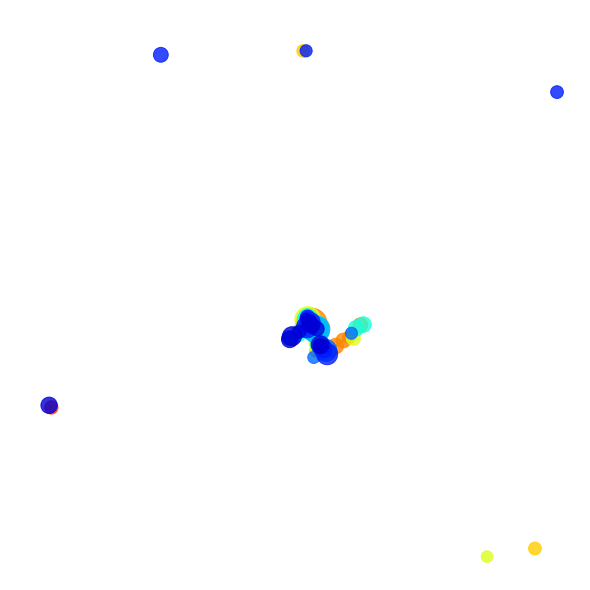

In [12]:
plt.figure(figsize=(8,8))
draw_graph(G)